In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
years = range(2000,2015)

pieces = []
columns = ['When Reported','Offense Code','location']

for year in years:
    path = 'C:/Users/flunk_000/Desktop/CalPoly/StakeOut/%d.csv' % year
    frame = pd.read_csv(path, names=columns, header = True)

    pieces.append(frame)

crimeData = pd.concat(pieces, ignore_index=True)

#Total Crime/Day

In [3]:
for i in range(len(crimeData['location'])):
    if crimeData['location'][i] == 'LZ1':
        crimeData['location'][i]=1
    if crimeData['location'][i] =='LZ2':
        crimeData['location'][i]=2
    if crimeData['location'][i]=='LZ3':
        crimeData['location'][i]=3

In [4]:
crimeData['When Reported'] = [datetime.datetime.strptime(date, '%H:%M:%S %m/%d/%Y') for date in crimeData['When Reported']]

In [5]:
crimeData['When Reported'] = sorted(crimeData['When Reported'])

In [6]:
ts = pd.Series(crimeData['location'],index=crimeData['When Reported'])
ts[0:] = 1

In [7]:
byDay = ts.resample('D',how='sum')

In [8]:
mean=round(np.mean(byDay),2)
std=round(np.std(byDay),2)

## Total Crime: Visualization

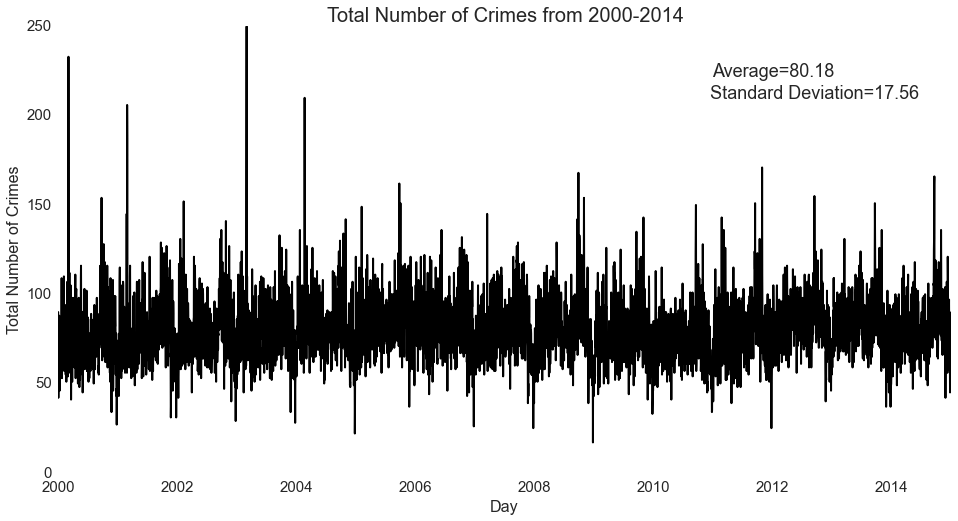

In [9]:
figure = plt.figure(figsize=(16,8))
TSPlot = byDay.plot(linewidth=2, c='black')

TSPlot.set_ylabel('Total Number of Crimes', fontsize=16)
TSPlot.set_xlabel('Day',fontsize=16)
TSPlot.set_title('Total Number of Crimes from 2000-2014',fontsize=20)
plt.tick_params(axis='both', labelsize=15)

#### ADD STATISTICS TEXT####
TSPlot.text(0.8, 0.9,'Average=%.2f' %mean, ha='center', va='center', transform=TSPlot.transAxes, fontsize = 18)
TSPlot.text(0.8465, 0.85,'Standard Deviation=%.2f' %std, ha='center', va='center', transform=TSPlot.transAxes, fontsize = 18);

##Total Crime: Harmonic Model 

In [125]:
print(len(byDay[1383:5479]));

4096


In [126]:
ffts = {'1stWindow':np.fft.fft(byDay[1383:5479])}

In [127]:
harmonicDF = pd.DataFrame(ffts)

In [128]:
def imabs(complexNum):
    return 2*abs(complexNum)/float(4096)

def imarg(complexNum):
    return math.atan2(complexNum.imag,complexNum.real)

def sine_wave(time,amp,freq,phi,damp):
    return ((math.exp(-1*damp*time))*
            (amp*math.sin(2*math.pi*freq*time-phi)))

In [129]:
harmonicDF['peakAmp1']= harmonicDF.apply(lambda row: imabs(row['1stWindow']), axis=1)

In [130]:
harmonicDF['peakAmp1'][0] = 0
harmonicDF['peakAmp1'][2047] = abs(harmonicDF['1stWindow'][2047])

In [131]:
harmonicDF['k'] = np.arange(len(harmonicDF))

In [132]:
harmonicDF['freq'] = harmonicDF['k']/(4096)

In [133]:
harmonicDF['phase(rad)1']= harmonicDF.apply(lambda row: imarg(row['1stWindow']), axis=1)

In [134]:
peakDF = harmonicDF.filter(regex='peakAmp1')

### Check dominate period (1 week)

In [135]:
1/harmonicDF['freq'][585]

7.0017094017094017

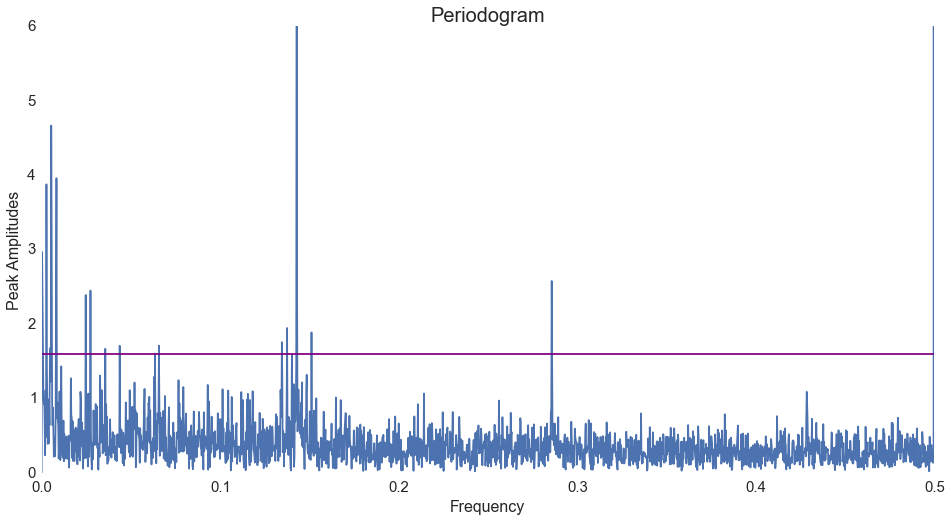

In [136]:
figure = plt.figure(figsize = (16,8))
plt.plot(harmonicDF['freq'], harmonicDF['peakAmp1'])
plt.ylim(0,6)
plt.xlim(0,.5)
plt.axhline(1.6,0, color='purple')
plt.ylabel('Peak Amplitudes', fontsize = 16)
plt.xlabel('Frequency', fontsize = 16)
plt.tick_params(axis='both', labelsize=15)
plt.title('Periodogram', fontsize = 20);

In [166]:
index = pd.date_range('2000-01-01', periods=5479, freq='D')
waveDF = pd.DataFrame(mdates.date2num(index), columns=['time'])
waveDF['When Reported'] = index

In [167]:
peakDFsorted = peakDF.sort(['peakAmp1'],ascending=False);
amp1st = peakDFsorted['peakAmp1'][1:43]

In [168]:
amp1st

585     9.196324
3511    9.196324
22      4.666792
4074    4.666792
4062    3.959619
34      3.959619
4085    3.877490
11      3.877490
4073    3.120261
23      3.120261
1       2.967461
4095    2.967461
2926    2.577731
1170    2.577731
112     2.449477
3984    2.449477
3995    2.388862
101     2.388862
3510    2.377270
586     2.377270
2       2.252959
4094    2.252959
33      2.238023
4063    2.238023
3533    1.946172
563     1.946172
619     1.886767
3477    1.886767
3545    1.756204
551     1.756204
3827    1.707928
269     1.707928
179     1.707167
3917    1.707167
4093    1.700159
3       1.700159
19      1.673693
4077    1.673693
146     1.667222
3950    1.667222
3836    1.602754
260     1.602754
Name: peakAmp1, dtype: float64

In [218]:
periods = []
for i in [585,22,34,11,23,1,1170,112,101,586,2,33,563,619,551,269,179,3,19,146,260]:
    periods.append(1/harmonicDF['freq'][i])
periods

[7.0017094017094017,
 186.18181818181819,
 120.47058823529412,
 372.36363636363637,
 178.08695652173913,
 4096.0,
 3.5008547008547009,
 36.571428571428569,
 40.554455445544555,
 6.9897610921501707,
 2048.0,
 124.12121212121212,
 7.2753108348134994,
 6.6171243941841684,
 7.4337568058076222,
 15.226765799256505,
 22.882681564245811,
 1365.3333333333333,
 215.57894736842104,
 28.054794520547944,
 15.753846153846155]

In [169]:
indices = [585,22,34,11,23,1,1170,112,101,586,2,33,563,619,551,269,179,3,19,146,260]
k=1

for j in range(len(indices)):
    amp = harmonicDF['peakAmp1'][indices[j]]
    freq = harmonicDF['freq'][indices[j]]
    phi = harmonicDF['phase(rad)1'][indices[j]]
    damp=0
    
    waveDF['SineValues%d' %int(k)]= waveDF.apply(lambda row: sine_wave(row['time'],amp,freq,phi,damp),axis=1)
    k+=1

In [170]:
interval1 = waveDF.copy()

In [171]:
del interval1['time']
del interval1['When Reported']

In [172]:
waveDF['agWave'] = (interval1.sum(axis=1))

In [173]:
wave1 = pd.Series(waveDF['agWave'],index=waveDF['When Reported'])
wave1[0:] = waveDF['agWave']+80.18

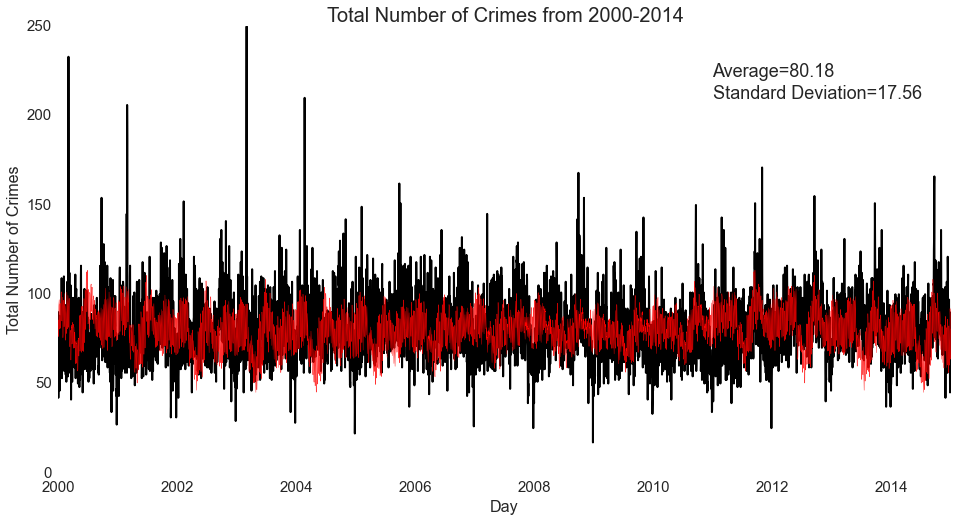

In [174]:
figure = plt.figure(figsize=(16,8))
TSPlot = byDay.plot(linewidth=2, c='black')
wave1.plot(linewidth=.4,c='red')

TSPlot.set_ylabel('Total Number of Crimes', fontsize=16)
TSPlot.set_xlabel('Day',fontsize=16)
TSPlot.set_title('Total Number of Crimes from 2000-2014',fontsize=20)
plt.tick_params(axis='both', labelsize=15)

#### ADD STATISTICS TEXT####
TSPlot.text(0.8, 0.9,'Average=%.2f' %mean, ha='center', va='center', transform=TSPlot.transAxes, fontsize = 18)
TSPlot.text(0.85, 0.85,'Standard Deviation=%.2f' %std, ha='center', va='center', transform=TSPlot.transAxes, fontsize = 18);

In [175]:
def calc_resid(obs,pred):
    return obs-pred

In [176]:
waveDF['byDay'] = byDay
for i in range(len(waveDF)):
    waveDF['byDay'][i] = byDay[i]

In [177]:
SSE = np.sum((waveDF['byDay']-waveDF['agWave'])**2)
meanTheta = np.mean(waveDF['byDay'])
SSM = np.sum((waveDF['agWave']-meanTheta)**2)
SST = SSM + SSE
rsquare = 1-(SSE/SST)
print(SSE,SSM,SST,rsquare)

(37164560.814045824, 35736139.078409739, 72900699.892455563, 0.49020296281281717)


In [178]:
waveDF['Residuals']= waveDF.apply(lambda row: calc_resid(row['agWave'],row['byDay']), axis=1)
waveDF['Residuals']= waveDF['Residuals']+mean

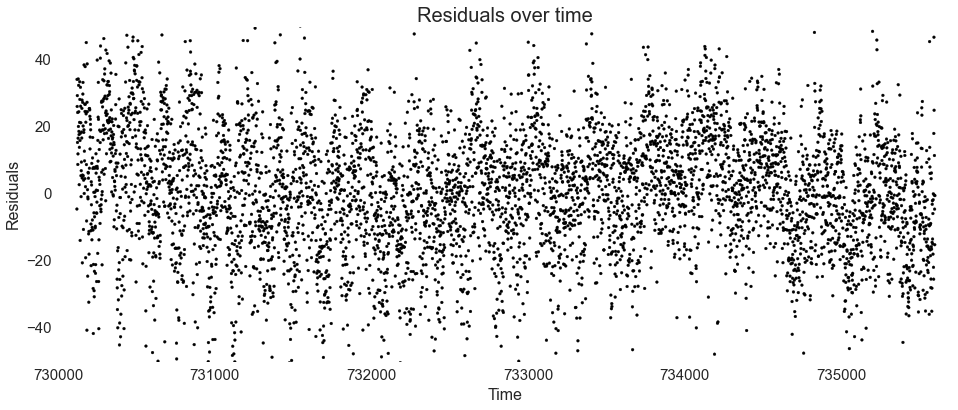

In [179]:
fig = plt.figure(figsize=(16,6))
residPlt = plt.scatter(waveDF['time'],waveDF['Residuals'], s=8, c='black')

plt.ylim(-50,50)
plt.xlim(730000,735700);
plt.ylabel('Residuals', fontsize = 16)
plt.xlabel('Time', fontsize = 16)
plt.tick_params(axis='both', labelsize=15)
plt.title('Residuals over time', fontsize = 20);

###Identify preiods within residuals 

In [180]:
fftResid = {'1stWindow':np.fft.fft(waveDF['Residuals'][1383:5479])}

In [181]:
harmonicDFresid = pd.DataFrame(fftResid)

In [182]:
harmonicDFresid['peakAmp1']= harmonicDFresid.apply(lambda row: imabs(row['1stWindow']), axis=1)

In [183]:
harmonicDFresid['peakAmp1'][0] = 0
harmonicDFresid['peakAmp1'][2047] = abs(harmonicDFresid['1stWindow'][2047])

In [184]:
harmonicDFresid['phase(rad)1']= harmonicDFresid.apply(lambda row: imarg(row['1stWindow']), axis=1)

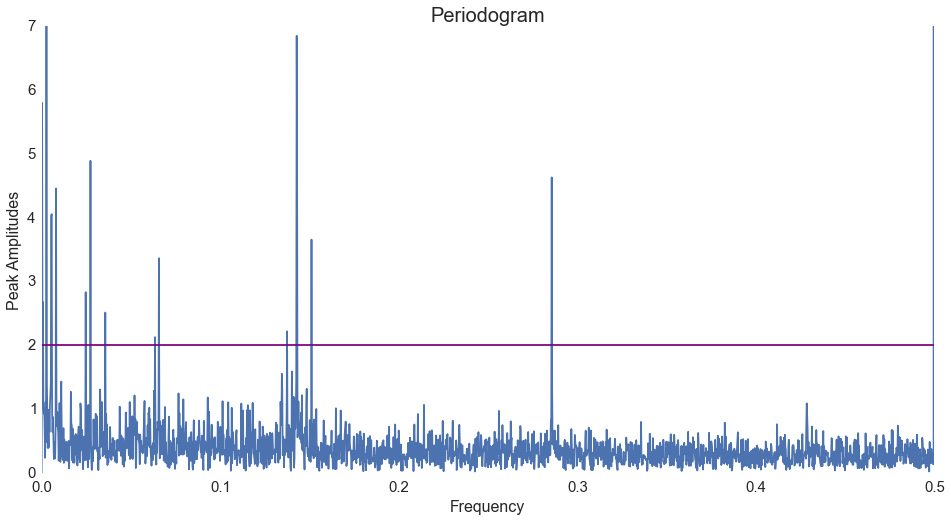

In [211]:
figure = plt.figure(figsize = (16,8))
plt.plot(harmonicDF['freq'], harmonicDFresid['peakAmp1'])
plt.ylim(0,7)
plt.xlim(0,.5)
plt.axhline(2,0, color='purple')
plt.ylabel('Peak Amplitudes', fontsize = 16)
plt.xlabel('Frequency', fontsize = 16)
plt.tick_params(axis='both', labelsize=15)
plt.title('Periodogram', fontsize = 20);

In [186]:
peakDFresid = harmonicDFresid.filter(regex='peakAmp1')

In [187]:
peakDFsortedResid = peakDFresid.sort(['peakAmp1'],ascending=False);
amp1stResid = peakDFsortedResid['peakAmp1'][1:30]

In [188]:
amp1stResid

4085    7.155642
11      7.155642
585     6.851714
3511    6.851714
4095    5.800502
1       5.800502
112     4.892147
3984    4.892147
586     4.646544
3510    4.646544
1170    4.632073
2926    4.632073
4063    4.459936
33      4.459936
4073    4.056676
23      4.056676
22      4.027086
4074    4.027086
619     3.656840
3477    3.656840
269     3.364933
3827    3.364933
3995    2.831694
101     2.831694
4093    2.676708
3       2.676708
3950    2.512642
146     2.512642
563     2.218763
Name: peakAmp1, dtype: float64

In [213]:
periods = []
for i in [11,585,1,112,586,1170,33,23,22,619,269,101,3,146,563]:
    periods.append(1/harmonicDF['freq'][i])
periods

[372.36363636363637,
 7.0017094017094017,
 4096.0,
 36.571428571428569,
 6.9897610921501707,
 3.5008547008547009,
 124.12121212121212,
 178.08695652173913,
 186.18181818181819,
 6.6171243941841684,
 15.226765799256505,
 40.554455445544555,
 1365.3333333333333,
 28.054794520547944,
 7.2753108348134994]

In [192]:
indices = [11,585,1,112,586,1170,33,23,22,619,269,101,3,146,563]
k=22

for j in range(len(indices)):
    amp = harmonicDFresid['peakAmp1'][indices[j]]
    freq = harmonicDF['freq'][indices[j]]
    phi = harmonicDFresid['phase(rad)1'][indices[j]]
    damp=0
    
    waveDF['SineValues%d' %int(k)]= waveDF.apply(lambda row: sine_wave(row['time'],amp,freq,phi,damp),axis=1)
    k+=1

In [194]:
interval1 = waveDF.copy()

In [195]:
del interval1['time']
del interval1['When Reported']

In [197]:
waveDF['agWave'] = interval1.sum(axis=1)

In [200]:
wave1 = pd.Series(waveDF['agWave'],index=waveDF['When Reported'])
wave1[0:] = waveDF['agWave']

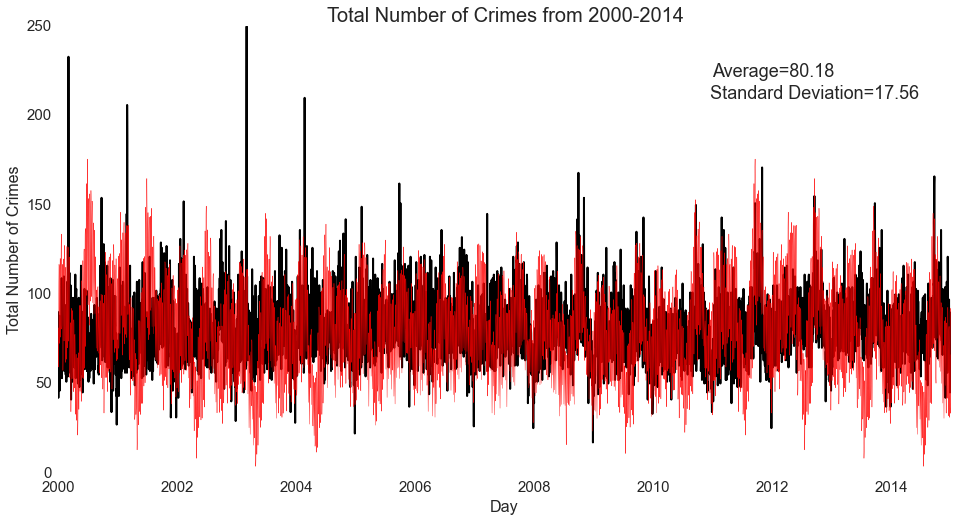

In [201]:
figure = plt.figure(figsize=(16,8))
TSPlot = byDay.plot(linewidth=2, c='black')
wave1.plot(linewidth=.4,c='red')

TSPlot.set_ylabel('Total Number of Crimes', fontsize=16)
TSPlot.set_xlabel('Day',fontsize=16)
TSPlot.set_title('Total Number of Crimes from 2000-2014',fontsize=20)
plt.tick_params(axis='both', labelsize=15)

#### ADD STATISTICS TEXT####
TSPlot.text(0.8, 0.9,'Average=%.2f' %mean, ha='center', va='center', transform=TSPlot.transAxes, fontsize = 18)
TSPlot.text(0.8465, 0.85,'Standard Deviation=%.2f' %std, ha='center', va='center', transform=TSPlot.transAxes, fontsize = 18);

In [204]:
waveDF['Residuals']= waveDF.apply(lambda row: calc_resid(row['agWave'],row['byDay']), axis=1)
waveDF['Residuals']= waveDF['Residuals']

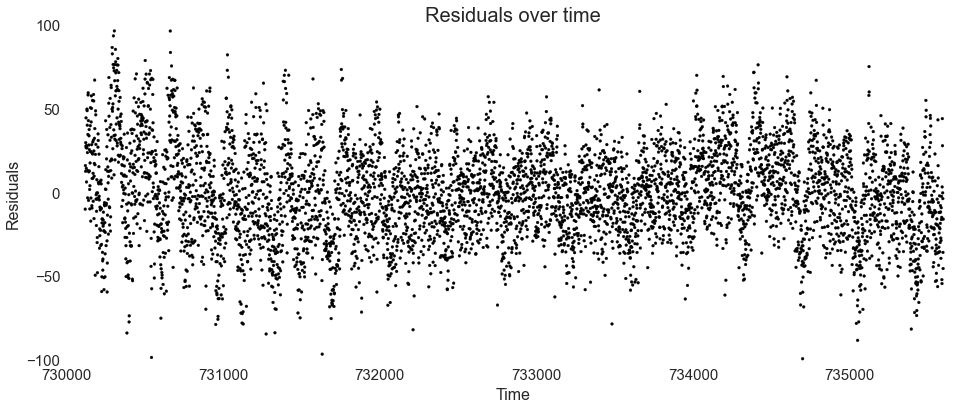

In [207]:
fig = plt.figure(figsize=(16,6))
residPlt = plt.scatter(waveDF['time'],waveDF['Residuals'], s=8, c='black')

plt.ylim(-100,100)
plt.xlim(730000,735700);
plt.ylabel('Residuals', fontsize = 16)
plt.xlabel('Time', fontsize = 16)
plt.tick_params(axis='both', labelsize=15)
plt.title('Residuals over time', fontsize = 20);

In [266]:
waveDF.to_csv('C:/Users/flunk_000/Desktop/CalPoly/StakeOut/toArima.csv', index=True)

# Total Crime/Day, by Zone 

In [11]:
z1 = crimeData.query('location == 1')
z2 = crimeData.query('location == 2')
z3 = crimeData.query('location == 3')

In [12]:
print('Total crime for zone 1:',len(z1));print('Total crime for zone 2:',len(z2));print('Total crime for zone 3:',(len(z3)))

('Total crime for zone 1:', 167318)
('Total crime for zone 2:', 176247)
('Total crime for zone 3:', 75107)


In [13]:
z1 = z1.reset_index();
z2 = z2.reset_index();
z3 = z3.reset_index();

In [14]:
del z1['index']
del z2['index']
del z3['index']

In [15]:
z1TS = pd.Series(z1['location'],index=z1['When Reported'])
z1TS[0:] = 1

z2TS = pd.Series(z1['location'],index=z2['When Reported'])
z2TS[0:] = 1

z3TS = pd.Series(z1['location'],index=z3['When Reported'])
z3TS[0:] = 1

In [16]:
z1TS = z1TS.resample('D',how='sum')
z2TS = z2TS.resample('D',how='sum')
z3TS = z3TS.resample('D',how='sum')

In [17]:
z1mean = round(np.mean(z1TS),2)
z1std = round(np.std(z1TS),2)

z2mean = round(np.mean(z2TS),2)
z2std = round(np.std(z2TS),2)

z3mean = round(np.mean(z3TS),2)
z3std = round(np.std(z3TS),2)

## Crime by Zone: Visualization

In [18]:
from matplotlib.gridspec import GridSpec

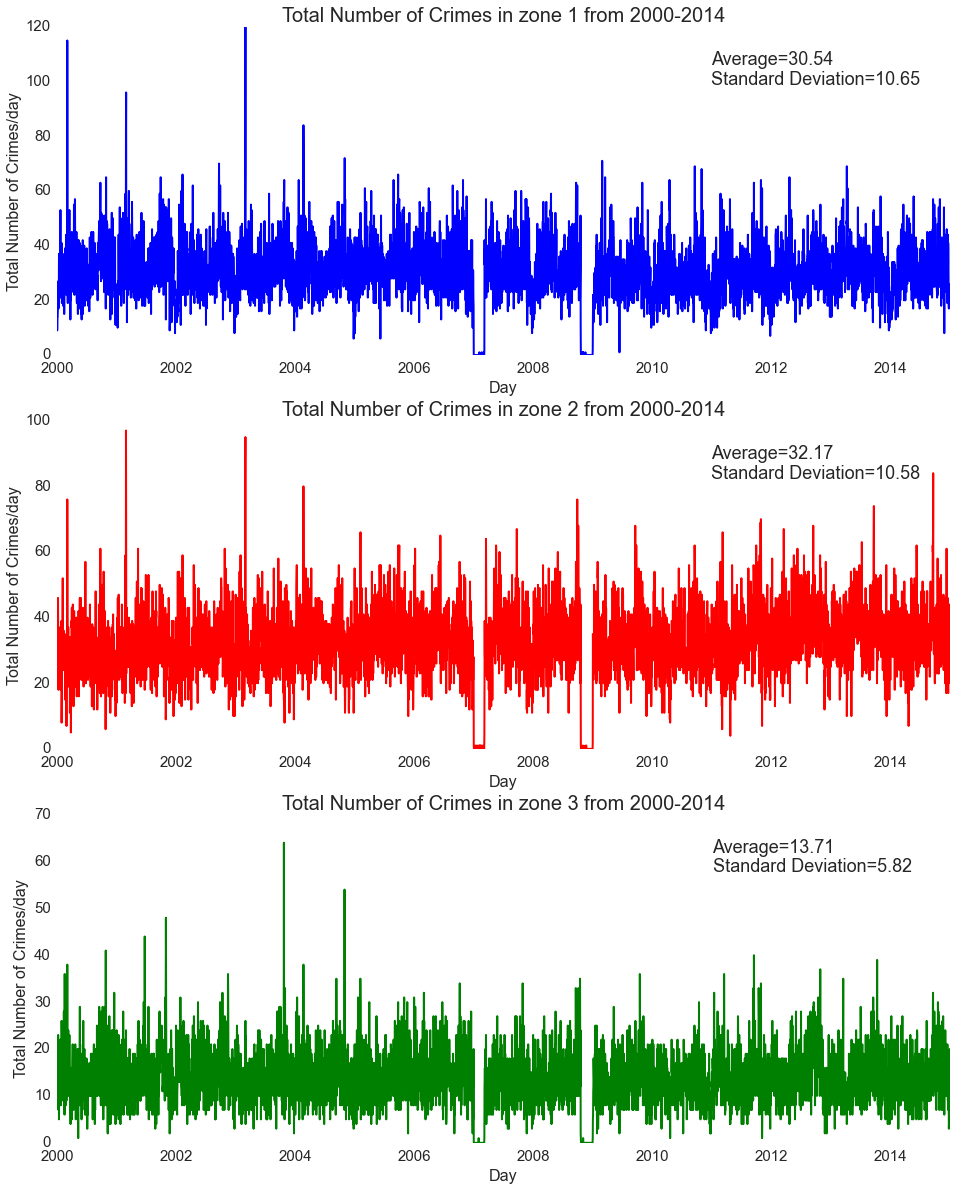

In [32]:
figure = plt.figure(figsize=(16,20))
gs = GridSpec(3,1)

z1plot = figure.add_subplot(gs[0,0])
z1plot =z1TS.plot(linewidth=2, c='blue')
z1plot.set_ylabel('Total Number of Crimes/day', fontsize=16)
z1plot.set_xlabel('Day',fontsize=16)
z1plot.set_title('Total Number of Crimes in zone 1 from 2000-2014',fontsize=20)
z1plot.tick_params(axis='both', labelsize=15)
z1plot.text(0.8, 0.9,'Average=%.2f' %z1mean, ha='center', va='center', transform=z1plot.transAxes, fontsize = 18)
z1plot.text(0.849, 0.84,'Standard Deviation=%.2f' %z1std, ha='center', va='center', transform=z1plot.transAxes, fontsize = 18);

z2plot = figure.add_subplot(gs[1,0])
z2plot = z2TS.plot(linewidth=2, c='red')
z2plot.set_ylabel('Total Number of Crimes/day', fontsize=16)
z2plot.set_xlabel('Day',fontsize=16)
z2plot.set_title('Total Number of Crimes in zone 2 from 2000-2014',fontsize=20)
z2plot.tick_params(axis='both', labelsize=15)
z2plot.text(0.8, 0.9,'Average=%.2f' %z2mean, ha='center', va='center', transform=z2plot.transAxes, fontsize = 18)
z2plot.text(0.849, 0.84,'Standard Deviation=%.2f' %z2std, ha='center', va='center', transform=z2plot.transAxes, fontsize = 18);

z3plot = figure.add_subplot(gs[2,0])
z3plot = z3TS.plot(linewidth=2, c='green')
z3plot.set_ylabel('Total Number of Crimes/day', fontsize=16)
z3plot.set_xlabel('Day',fontsize=16)
z3plot.set_title('Total Number of Crimes in zone 3 from 2000-2014',fontsize=20)
z3plot.tick_params(axis='both', labelsize=15)
z3plot.text(0.8, 0.9,'Average=%.2f' %z3mean, ha='center', va='center', transform=z3plot.transAxes, fontsize = 18)
z3plot.text(0.846, 0.84,'Standard Deviation=%.2f' %z3std, ha='center', va='center', transform=z3plot.transAxes, fontsize = 18);

##Crime by Zone: Harmonic Model 